#notebooks.clustering_task

As unsupervised task we consider a set of DNA sequences with
the goal of finding biologically meaningful patterns
Due to computational limitations, we use small DNA
sequences, yet these are of pivotal importance in biomolecular
applications, taking inspiration from [github.com/
millacurafa/nullomer_search](https://github.com/millacurafa/nullomer_search).

If needed, execute the following commands

```
!git clone https://github.com/leonardoLavagna/qhdc
import os
os.chdir('qhdc')
!pip install -r requirements.txt
```

In [2]:
from sklearn.cluster import KMeans
import numpy as np
from functions.circuits_utilities import generate_random_circuit_from_sequence, measure_zero_probability
from functions.QUAM import *

In [3]:
# Global variable: number of clusters
k = 3

## Quam-based architecture

In [4]:
# Example dataset
dna_sequences = ['GTA', 'GTT', 'CT', 'TAC']

In [5]:
def dna_to_binary(sequence, max_length=2):
    """
    Convert a DNA sequence to a binary representation.
    Each nucleotide is mapped to a 2-bit binary string:
    A -> 00, T -> 01, G -> 10, C -> 11
    """
    mapping = {'A': '00', 'T': '01', 'G': '10', 'C': '11'}
    binary_sequence = ''.join(mapping[nuc] for nuc in sequence)
    binary_sequence = binary_sequence[:max_length*2].ljust(max_length*2, '0')
    return binary_sequence

In [6]:
def cluster_dna_sequences(dna_sequences):
    """
    Cluster DNA sequences the QuAM-based architecture.
    """
    max_length = max([len(seq) for seq in dna_sequences])
    binary_patterns = [dna_to_binary(seq, max_length) for seq in dna_sequences]
    clusters = {}
    for i, query_pattern in enumerate(binary_patterns):
        state, data = QuAM(binary_patterns, search=query_pattern)
        similar_patterns = [pattern for pattern, count in data.items() if count > 0]
        for pattern in similar_patterns:
            if pattern not in clusters:
                clusters[pattern] = []
            clusters[pattern].append(dna_sequences[i])
    return clusters

In [7]:
clusters = cluster_dna_sequences(dna_sequences)
#for cluster_id, sequences in clusters.items():
#    print(f"Cluster {cluster_id}: {sequences}")

In [8]:
# List of all unique sequences
all_sequences = sorted(set(seq for cluster in clusters.values() for seq in cluster))

# Create a binary matrix where each sequence is a row and each cluster is a column
sequence_to_index = {seq: i for i, seq in enumerate(all_sequences)}
cluster_to_index = {cluster_id: i for i, cluster_id in enumerate(clusters.keys())}

# Initialize a binary matrix for sequences and clusters
binary_matrix = np.zeros((len(all_sequences), len(clusters)))

# Fill the binary matrix (1 if the sequence is part of the cluster, else 0)
for cluster_id, sequences in clusters.items():
    cluster_index = cluster_to_index[cluster_id]
    for seq in sequences:
        sequence_index = sequence_to_index[seq]
        binary_matrix[sequence_index, cluster_index] = 1

# Apply K-Means clustering to the binary matrix
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(binary_matrix)
for seq, cluster_label in zip(all_sequences, labels):
    print(f"Sequence: {seq}, Cluster: {cluster_label}")

Sequence: CT, Cluster: 2
Sequence: GTA, Cluster: 0
Sequence: GTT, Cluster: 1
Sequence: TAC, Cluster: 0


## Circuit-based architecture

In [14]:
# Example dataset
dna_sequences = ['GTA', 'GTT', 'CT', 'TAC', 'GTAAA', 'GTTCCGCCA', 'CTGTCT', 'TGATGCACA', 'TACACACAGA',
                'ACAATCG', 'GTCAATGGCC', 'CCA', 'GCGC', 'GCTTGACGG']

In [15]:
probabilities = []
for sequence in dna_sequences:
    qc = generate_random_circuit_from_sequence(sequence)
    p_zero = measure_zero_probability(qc)
    probabilities.append(p_zero)

kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(np.array(probabilities).reshape(-1, 1))
for sequence, cluster in zip(dna_sequences, clusters):
    print(f"Sequence: {sequence}, Cluster: {cluster}")

Sequence: GTA, Cluster: 0
Sequence: GTT, Cluster: 2
Sequence: CT, Cluster: 1
Sequence: TAC, Cluster: 2
Sequence: GTAAA, Cluster: 1
Sequence: GTTCCGCCA, Cluster: 1
Sequence: CTGTCT, Cluster: 0
Sequence: TGATGCACA, Cluster: 1
Sequence: TACACACAGA, Cluster: 2
Sequence: ACAATCG, Cluster: 0
Sequence: GTCAATGGCC, Cluster: 1
Sequence: CCA, Cluster: 0
Sequence: GCGC, Cluster: 1
Sequence: GCTTGACGG, Cluster: 1


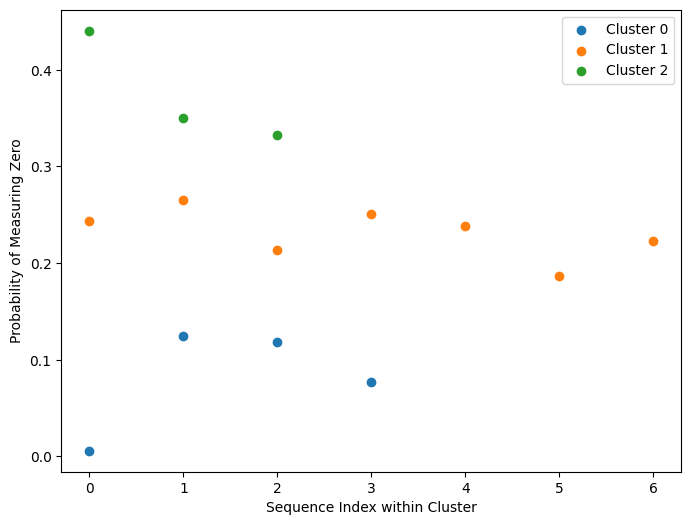

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(k):
    cluster_sequences = [seq for seq, cluster in zip(dna_sequences, clusters) if cluster == i]
    cluster_probabilities = [prob for prob, cluster in zip(probabilities, clusters) if cluster == i]
    plt.scatter(range(len(cluster_probabilities)), cluster_probabilities, label=f'Cluster {i}')

plt.xlabel('Sequence Index within Cluster')
plt.ylabel('Probability of Measuring Zero')
#plt.title('Clusters Grouped by Probabilities')
plt.legend()
plt.show()